# OPTICS + H3 Heterogeneity (using detections.gpkg)

This notebook re-runs the OPTICS + H3 aggregation workflow but reads real detections from `detections.gpkg` instead of simulated data.

Notes: the notebook assumes `detections.gpkg` is in the same directory as this notebook. Cluster algorithms use a projected CRS (EPSG:3857) for Euclidean distance calculations; H3 aggregation uses EPSG:4326 (lat/lon).

In [1]:
# Imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from sklearn.cluster import OPTICS, DBSCAN
import h3
import warnings
warnings.filterwarnings('ignore')


## Load detections.gpkg

In [2]:
# Load detections.gpkg and prepare data for clustering and H3
import numpy as np
import geopandas as gpd

# Path to the geopackage (assumes same folder)
gpkg_path = 'detections.gpkg'

# Read the layer (if multiple layers exist, read_file will pick the first by default)
gdf = gpd.read_file(gpkg_path)
print('Loaded layer with', len(gdf), 'features')
print('Original CRS:', gdf.crs)

# Ensure point geometries (if geometries are not points, attempt to get centroids)
if not all(gdf.geometry.geom_type == 'Point'):
    print('Converting non-point geometries to centroids for clustering')
    gdf = gdf.copy()
    gdf['geometry'] = gdf.geometry.centroid

# Projected CRS for clustering (New Zealand Transverse Mercator EPSG:2193)
gdf_proj = gdf.to_crs('EPSG:2193')

# Coordinates array for clustering (x,y in projected units)
coords = np.array([[pt.x, pt.y] for pt in gdf_proj.geometry], dtype=float)
print('Prepared coordinates array with shape:', coords.shape)

# WGS84 for H3 (lat, lon)
gdf_wgs = gdf.to_crs('EPSG:4326')
latlon = [(pt.y, pt.x) for pt in gdf_wgs.geometry]
print('Prepared lat/lon pairs for H3:', len(latlon))

Loaded layer with 4209 features
Original CRS: EPSG:2193
Prepared coordinates array with shape: (4209, 2)
Prepared lat/lon pairs for H3: 4209


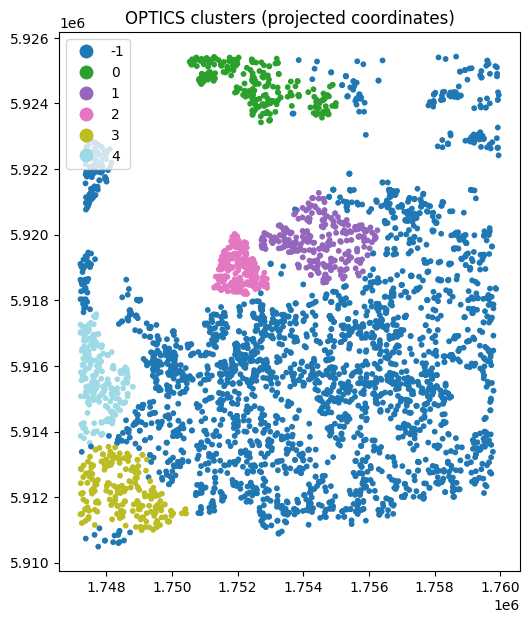

In [36]:
# OPTICS clustering (projected coords)
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

# Configure and run OPTICS (tune parameters as needed)
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
optics.fit(coords)

# Attach labels to the projected GeoDataFrame
gdf_proj = gdf_proj.copy()
gdf_proj['optics_cluster'] = optics.labels_

# Quick plot of OPTICS clusters
fig, ax = plt.subplots(figsize=(9,7))
gdf_proj.plot(column='optics_cluster', categorical=True, cmap='tab20', legend=True, markersize=10, ax=ax)
plt.title('OPTICS clusters (projected coordinates)')
plt.show()

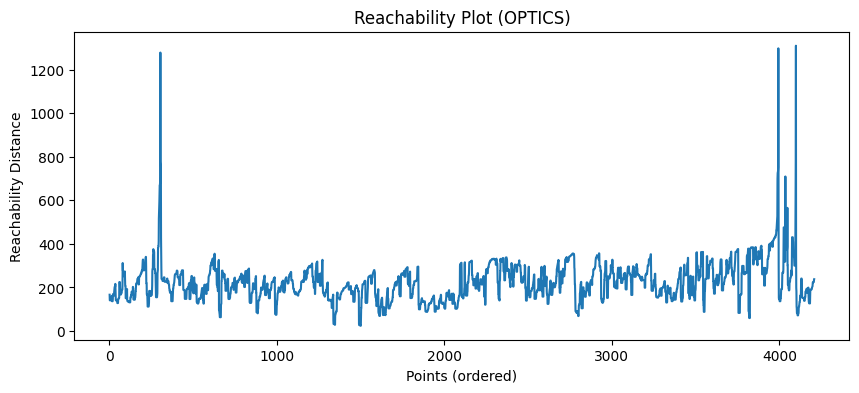

In [37]:
# Reachability plot for OPTICS
plt.figure(figsize=(10,4))
plt.plot(optics.reachability_[optics.ordering_])
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Points (ordered)')
plt.ylabel('Reachability Distance')
plt.show()

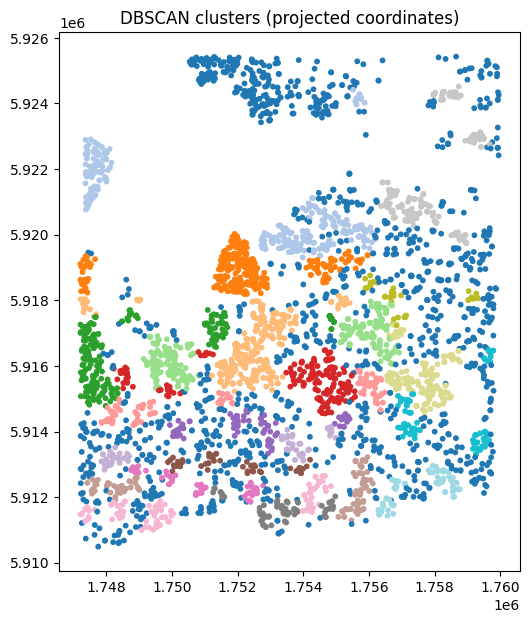

In [3]:
# DBSCAN for comparison (projected coords)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=250, min_samples=10)  # eps in meters (tune as needed)
dbscan.fit(coords)
gdf_proj['dbscan_cluster'] = dbscan.labels_
fig, ax = plt.subplots(figsize=(9,7))
gdf_proj.plot(column='dbscan_cluster', categorical=True, cmap='tab20', legend=False, markersize=10, ax=ax)
plt.title('DBSCAN clusters (projected coordinates)')
plt.show()

## DBSCAN for comparison

## Aggregate into H3 hexagons (use lat/lon)

In [39]:
# Reproject to WGS84 for H3 (lat, lon)
gdf_wgs = gdf.to_crs('EPSG:4326')

# Drop null/empty geometries just in case
gdf_wgs = gdf_wgs[gdf_wgs.geometry.notnull() & ~gdf_wgs.geometry.is_empty]

# Prepare (lat, lon) pairs from geometry (H3 expects lat, lon)
latlon = [(pt.y, pt.x) for pt in gdf_wgs.geometry]

# Choose H3 resolution (tune for scale of interest)
resolution = 8

# Robustly find the geo_to_h3 callable in the installed h3 package
import types
def _find_geo_to_h3(mod):
    # direct attribute
    if hasattr(mod, 'geo_to_h3') and callable(getattr(mod, 'geo_to_h3')):
        return getattr(mod, 'geo_to_h3')
    # scan attributes for a geo-like function
    for name in dir(mod):
        try:
            attr = getattr(mod, name)
        except Exception:
            continue
        if callable(attr) and 'geo' in name and 'h3' in name:
            return attr
    # scan submodules
    for name in dir(mod):
        try:
            attr = getattr(mod, name)
        except Exception:
            continue
        if isinstance(attr, types.ModuleType):
            for n2 in dir(attr):
                try:
                    f = getattr(attr, n2)
                except Exception:
                    continue
                if callable(f) and 'geo' in n2:
                    return f
    return None


In [40]:
# Compute H3 indices using a robust approach for h3-py v4
import importlib, h3, numpy as np
from shapely.geometry import Point as _Point, Polygon, shape as _shape

# Ensure latlon exists (kernel may have been restarted)
if 'latlon' not in globals():
    if 'gdf_wgs' in globals():
        latlon = [(pt.y, pt.x) for pt in gdf_wgs.geometry]
    elif 'gdf' in globals():
        gdf_wgs = gdf.to_crs('EPSG:4326')
        latlon = [(pt.y, pt.x) for pt in gdf_wgs.geometry]
    else:
        raise RuntimeError('latlon not defined and gdf/gdf_wgs not available. Run the earlier cells that load detections.gpkg')

# Try direct point→cell methods first (various naming across versions)
def _try_point_to_cell_direct(lat, lon, res):
    # top-level h3 first
    if hasattr(h3, 'latlng_to_cell'):
        try:
            return h3.latlng_to_cell(lat, lon, res)
        except Exception:
            pass
    if hasattr(h3, 'lat_lng_to_cell'):
        try:
            return h3.lat_lng_to_cell(lat, lon, res)
        except Exception:
            pass
    if hasattr(h3, 'geo_to_h3'):
        try:
            return h3.geo_to_h3(lat, lon, res)
        except Exception:
            pass
    # submodules: basic_int / numpy_int / basic_str
    for modname in ('h3.api.basic_int', 'h3.api.numpy_int', 'h3.api.basic_str'):
        try:
            mod = importlib.import_module(modname)
        except Exception:
            continue
        for cand in ('latlng_to_cell', 'lat_lng_to_cell', 'geo_to_h3'):
            f = getattr(mod, cand, None)
            if callable(f):
                try:
                    return f(lat, lon, res)
                except Exception:
                    pass
    return None

# Fallback via polygon coverage methods (buffered point → cells)
def _point_to_cell_via_polygon(point, res):
    # Try increasing buffers (in degrees). Start reasonably large so at least one cell intersects.
    for buf_r in (0.002, 0.001, 0.0005):  # ~220m, 110m, 55m
        buf = point.buffer(buf_r)
        # 1) Submodules polygon_to_cells with shapely polygon
        for modname in ('h3.api.basic_int', 'h3.api.numpy_int', 'h3.api.basic_str'):
            try:
                mod = importlib.import_module(modname)
                poly_to_cells = getattr(mod, 'polygon_to_cells', None)
                if callable(poly_to_cells):
                    cells = poly_to_cells(buf, res)
                    if cells:
                        # cells can be set/list/np array; take first
                        if isinstance(cells, (set, list, tuple, np.ndarray)):
                            return list(cells)[0]
                        return cells
            except Exception:
                pass
        # 2) Top-level polygon_to_cells with GeoJSON-style lon-lat coordinates
        try:
            if hasattr(h3, 'polygon_to_cells'):
                ring_lonlat = list(buf.exterior.coords)  # [(lon,lat), ...]
                geojson = {'type': 'Polygon', 'coordinates': [ring_lonlat]}
                cells = h3.polygon_to_cells(geojson, res)
                if cells:
                    return list(cells)[0] if isinstance(cells, (set, list, tuple, np.ndarray)) else cells
        except Exception:
            pass
        # 3) Top-level polygon_to_cells with lat-lon tuples
        try:
            if hasattr(h3, 'polygon_to_cells'):
                ring_latlon = [(y, x) for (x, y) in buf.exterior.coords]
                cells = h3.polygon_to_cells(ring_latlon, res)
                if cells:
                    return list(cells)[0] if isinstance(cells, (set, list, tuple, np.ndarray)) else cells
        except Exception:
            pass
    return None

h3_indices = []
for lat, lon in latlon:
    # First, try direct mappings
    cell = _try_point_to_cell_direct(lat, lon, resolution)
    if cell is None:
        # Fallback: polygon coverage approach
        cell = _point_to_cell_via_polygon(_Point(lon, lat), resolution)
    if cell is None:
        raise RuntimeError(f'Could not determine H3 cell for point ({lat}, {lon}) at res {resolution}')
    # Keep cell id as-is (may be string or int depending on API)
    h3_indices.append(cell)

# Aggregate counts per hexagon
hex_counts = pd.Series(h3_indices).value_counts().reset_index()
hex_counts.columns = ['h3_index', 'count']

# Convert H3 cell to polygon. Prefer APIs matching the cell id type
from shapely.geometry import Polygon

def _cell_to_polygon(cell):
    # If string cell id: prefer basic_str
    if isinstance(cell, (str, np.str_)):
        try:
            mod = importlib.import_module('h3.api.basic_str')
            geojson = mod.cells_to_geo([cell])
            return _shape(geojson)
        except Exception:
            pass
    # try top-level cells_to_geo (v4)
    try:
        if hasattr(h3, 'cells_to_geo'):
            geojson = h3.cells_to_geo([cell])
            return _shape(geojson)
    except Exception:
        pass
    # try api.basic_int.cells_to_geo
    try:
        mod = importlib.import_module('h3.api.basic_int')
        geojson = mod.cells_to_geo([int(cell)])
        return _shape(geojson)
    except Exception:
        pass
    # try numpy_int
    try:
        mod = importlib.import_module('h3.api.numpy_int')
        geojson = mod.cells_to_geo([int(cell)])
        return _shape(geojson)
    except Exception:
        pass
    # final fallback: v3-style boundary
    try:
        if hasattr(h3, 'h3_to_geo_boundary'):
            c = int(cell) if not isinstance(cell, (str, np.str_)) else cell
            coords = h3.h3_to_geo_boundary(c, geo_json=True)
            return Polygon(coords)
    except Exception:
        pass
    raise RuntimeError('No function to convert an H3 cell to polygon found in the installed h3 package')

hex_polygons = [_cell_to_polygon(h) for h in hex_counts['h3_index']]
hex_gdf = gpd.GeoDataFrame(hex_counts, geometry=hex_polygons, crs='EPSG:4326')
print('Created', len(hex_gdf), 'hexagons at resolution', resolution)
print(hex_gdf.head())

Created 201 hexagons at resolution 8
          h3_index  count                                           geometry
0  88bb5002d5fffff     81  POLYGON ((174.71054 -36.85944, 174.70985 -36.8...
1  88bb5002c3fffff     73  POLYGON ((174.71054 -36.85944, 174.70571 -36.8...
2  88bb5002ddfffff     69  POLYGON ((174.7064 -36.86746, 174.70571 -36.86...
3  88bb501523fffff     66  POLYGON ((174.7147 -36.88945, 174.71401 -36.88...
4  88bb500219fffff     60  POLYGON ((174.7313 -36.89539, 174.73684 -36.89...


In [47]:
# Convert hex_gdf to persisted format (Geopackage)
hex_gdf.to_file('h3_hexagons.gpkg', layer='hexagons_res8', driver='GPKG')

## Visualise clusters and H3 hexagons


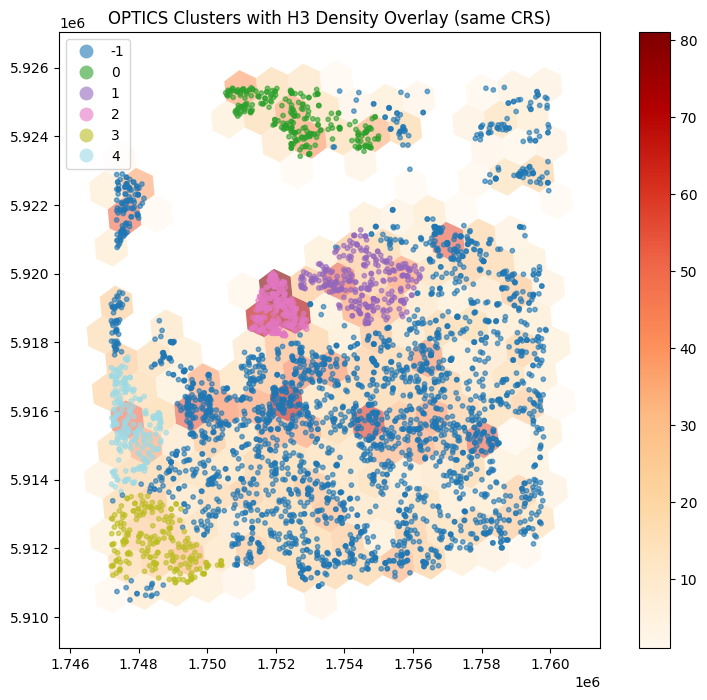

In [ ]:
# Visualize H3 density overlay and OPTICS clusters
fig, ax = plt.subplots(figsize=(10,8))
# Reproject hexagons to match projected clustering CRS for correct overlay
hex_gdf_proj = hex_gdf.to_crs(gdf_proj.crs)
hex_gdf_proj.plot(column='count', cmap='OrRd', legend=True, ax=ax, alpha=0.6, edgecolor='none')
# Make OPTICS clusters semi-transparent so density shows through
gdf_proj.plot(column='optics_cluster', categorical=True, ax=ax, markersize=10, cmap='tab20', legend=True, alpha=0.6, zorder=3)
plt.title("OPTICS Clusters with H3 Density Overlay (same CRS)")
plt.show()

# Compute Heterogeneity Metrics

In [42]:
# Compute heterogeneity metrics for hexagon counts
counts = hex_gdf['count'].values

# Variance
variance = np.var(counts)

# Gini coefficient
def gini(array):
    array = np.sort(array)
    n = len(array)
    cumulative = np.cumsum(array)
    return (n + 1 - 2 * np.sum(cumulative) / cumulative[-1]) / n

gini_coeff = gini(counts)

# Entropy
prob = counts / counts.sum()
entropy = -np.sum(prob * np.log(prob))

print(f"Variance: {variance}")
print(f"Gini Coefficient: {gini_coeff}")
print(f"Entropy: {entropy}")


Variance: 202.71285364223655
Gini Coefficient: 0.36362733729783014
Entropy: 5.0796428850291315


## Next Steps
- Apply workflow to real spatial data (ensure projected CRS for clustering).
- Experiment with different H3 resolutions for scale sensitivity.
- Use Local Moran's I or Gi* for hotspot analysis.
- Validate clustering results with Monte Carlo simulations.

In [43]:
# Appendix: H3 diagnostics (optional)
import importlib, h3
print('h3 module file:', getattr(h3, '__file__', 'unknown'))
print('h3 version:', getattr(h3, '__version__', None))
print('Has geo_to_cells:', hasattr(h3, 'geo_to_cells'))
print('Has cells_to_geo:', hasattr(h3, 'cells_to_geo'))
try:
    from shapely.geometry import Point as _P
    test_pt = _P(174.68833482111756, -36.80578080220762)
    if hasattr(h3, 'geo_to_cells'):
        try:
            res = h3.geo_to_cells(test_pt, 8)
            print('geo_to_cells(Point)-> OK type:', type(res))
        except Exception as e:
            print('geo_to_cells(Point) raised:', type(e).__name__, e)
    try:
        mod = importlib.import_module('h3.api.basic_int')
        if hasattr(mod, 'polygon_to_cells'):
            res2 = mod.polygon_to_cells(test_pt.buffer(0.001), 8)
            print('polygon_to_cells(buffered Point)-> OK type:', type(res2))
    except Exception as e:
        print('basic_int polygon_to_cells raised:', type(e).__name__, e)
except Exception as e:
    print('Diagnostic exception:', type(e).__name__, e)

h3 module file: /Users/tilmann/Documents/MSDS-CU_Boulder/CourseMaterials_CU_DataMiningProject/imagery/Cluster_Analysis/.venv/lib/python3.12/site-packages/h3/__init__.py
h3 version: 4.3.1
Has geo_to_cells: True
Has cells_to_geo: True
geo_to_cells(Point) raised: ValueError Unrecognized type: Point
basic_int polygon_to_cells raised: ValueError Unrecognized type: <class 'shapely.geometry.polygon.Polygon'>


In [44]:
# Quick introspection of h3 functions
import importlib, inspect, h3
print('Top-level candidates:')
print([n for n in dir(h3) if ('cell' in n.lower()) or ('lat' in n.lower()) or ('geo' in n.lower())])
for modname in ('h3.api.basic_int','h3.api.numpy_int','h3.api.basic_str','h3.api.numpy_str'):
    try:
        mod = importlib.import_module(modname)
        fns = [n for n in dir(mod) if callable(getattr(mod, n)) and (('cell' in n.lower()) or ('lat' in n.lower()) or ('geo' in n.lower()))]
        print(modname, '->', fns)
    except Exception as e:
        print(modname, 'import failed:', e)

Top-level candidates:
['H3CellInvalidError', 'H3LatLngDomainError', 'LatLngMultiPoly', 'LatLngPoly', 'are_neighbor_cells', 'cell_area', 'cell_to_boundary', 'cell_to_center_child', 'cell_to_child_pos', 'cell_to_children', 'cell_to_children_size', 'cell_to_latlng', 'cell_to_local_ij', 'cell_to_parent', 'cell_to_vertex', 'cell_to_vertexes', 'cells_to_directed_edge', 'cells_to_geo', 'cells_to_h3shape', 'child_pos_to_cell', 'compact_cells', 'directed_edge_to_cells', 'geo_to_cells', 'geo_to_h3shape', 'get_base_cell_number', 'get_num_cells', 'get_res0_cells', 'grid_path_cells', 'h3shape_to_cells', 'h3shape_to_cells_experimental', 'h3shape_to_geo', 'is_valid_cell', 'latlng_to_cell', 'local_ij_to_cell', 'polygon_to_cells', 'polygon_to_cells_experimental', 'uncompact_cells', 'vertex_to_latlng']
h3.api.basic_int -> ['LatLngMultiPoly', 'LatLngPoly', 'are_neighbor_cells', 'cell_area', 'cell_to_boundary', 'cell_to_center_child', 'cell_to_child_pos', 'cell_to_children', 'cell_to_children_size', 'cell

In [45]:
# Sanity check: direct latlng_to_cell on one point (lat, lon, res)
import h3
print('Test cell:', h3.latlng_to_cell(-36.80578080220762, 174.68833482111756, 8))

Test cell: 88bb500763fffff


In [46]:
# Quick test: convert one cell id to polygon coords via different APIs
import importlib, h3, pprint
cell_id = '88bb500763fffff'
try:
    r = h3.cells_to_geo([cell_id])
    print('top-level cells_to_geo keys:', r.keys())
    pprint.pp(next(iter(r.items())))
except Exception as e:
    print('top-level cells_to_geo failed:', e)
try:
    mod = importlib.import_module('h3.api.basic_str')
    r2 = mod.cells_to_geo([cell_id])
    print('basic_str cells_to_geo keys:', r2.keys())
    pprint.pp(next(iter(r2.items())))
except Exception as e:
    print('basic_str cells_to_geo failed:', e)
try:
    mod = importlib.import_module('h3.api.basic_int')
    r3 = mod.cells_to_geo([int(cell_id, 16)])
    print('basic_int cells_to_geo keys:', r3.keys())
    pprint.pp(next(iter(r3.items())))
except Exception as e:
    print('basic_int cells_to_geo failed:', e)

top-level cells_to_geo keys: dict_keys(['type', 'coordinates'])
('type', 'Polygon')
basic_str cells_to_geo keys: dict_keys(['type', 'coordinates'])
('type', 'Polygon')
basic_int cells_to_geo keys: dict_keys(['type', 'coordinates'])
('type', 'Polygon')


In [49]:
# Fast H3 aggregation by deduplicating points
import h3, numpy as np, pandas as pd
from shapely.geometry import shape as _shape

def fast_hex_aggregate(gdf_wgs, res=8):
    # build (lat, lon) array
    latlon = np.array([(pt.y, pt.x) for pt in gdf_wgs.geometry])
    # optional: round to ~1e-6 degrees to avoid tiny duplicates
    # Map each unique (lat,lon) once
    df = pd.DataFrame(latlon, columns=['lat','lon'])
    grouped = df.groupby(['lat','lon']).size().rename('n').reset_index()
    # map to h3 cell ids (strings)
    grouped['h3'] = grouped.apply(lambda r: h3.latlng_to_cell(r['lat'], r['lon'], res), axis=1)
    # count occurrences per cell, weighted by duplicates
    hex_counts = grouped.groupby('h3')['n'].sum().rename('count').reset_index()
    # build polygons via cells_to_geo (GeoJSON) + shapely
    polys = []
    for cid in hex_counts['h3']:
        geojson = h3.cells_to_geo([cid])
        polys.append(_shape(geojson))
    hex_gdf_fast = gpd.GeoDataFrame(hex_counts.rename(columns={'h3':'h3_index'}), geometry=polys, crs='EPSG:4326')
    return hex_gdf_fast

# Example usage
hex_gdf_fast = fast_hex_aggregate(gdf_wgs, res=8)
print('Fast aggregation produced', len(hex_gdf_fast), 'hexagons')

Fast aggregation produced 201 hexagons


In [50]:
# Install ipywidgets if missing (once per env)
import importlib, sys, subprocess
try:
    import ipywidgets as widgets  # noqa: F401
    print('ipywidgets is available')
except Exception:
    print('Installing ipywidgets...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'ipywidgets'])
    import ipywidgets as widgets
    print('ipywidgets installed')

Installing ipywidgets...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 1.5 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.4 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]3 [ipywidgets]
ipywidgets installed


In [ ]:
# Precompute unique lat/lon counts once for fast H3 recompute
import numpy as np, pandas as pd
# Build (lat, lon) array once from WGS84 geometries
_latlon_arr = np.array([(pt.y, pt.x) for pt in gdf_wgs.geometry])
_grouped_latlon = (
    pd.DataFrame(_latlon_arr, columns=['lat','lon'])
      .groupby(['lat','lon']).size().rename('n').reset_index()
)
print('Precomputed unique lat/lon pairs:', len(_grouped_latlon))

# Simple per-resolution cache for hex grids
_HEX_CACHE = {}

In [ ]:
# Interactive H3 resolution slider (cached, no continuous updates)
import ipywidgets as widgets
from IPython.display import display, clear_output
import h3

slider = widgets.IntSlider(min=6, max=10, step=1, value=8, description='H3 res', continuous_update=False)
out = widgets.Output()

def _compute_hex_for_res(res):
    if res in _HEX_CACHE:
        return _HEX_CACHE[res]
    # Map grouped unique lat/lon to H3 and aggregate
    cells = [_ for _ in (_ for _ in [])]  # placeholder to keep scope clean
    cells = [h3.latlng_to_cell(lat, lon, res) for lat, lon in zip(_grouped_latlon['lat'].values, _grouped_latlon['lon'].values)]
    hex_counts = (
        pd.DataFrame({'h3': cells, 'n': _grouped_latlon['n'].values})
          .groupby('h3')['n'].sum().rename('count').reset_index()
    )
    # Build polygons via cells_to_geo
    from shapely.geometry import shape as _shape
    polys = []
    for cid in hex_counts['h3']:
        geojson = h3.cells_to_geo([cid])
        polys.append(_shape(geojson))
    hex_df = gpd.GeoDataFrame(hex_counts.rename(columns={'h3':'h3_index'}), geometry=polys, crs='EPSG:4326')
    hex_df_proj = hex_df.to_crs(gdf_proj.crs)
    _HEX_CACHE[res] = hex_df_proj
    return hex_df_proj

@slider.observe
def _on_change(change):
    if change['name'] == 'value':
        with out:
            clear_output(wait=True)
            res = change['new']
            hex_df_proj = _compute_hex_for_res(res)
            fig, ax = plt.subplots(figsize=(10,8))
            hex_df_proj.plot(column='count', cmap='OrRd', legend=True, ax=ax, alpha=0.6, edgecolor='none')
            gdf_proj.plot(column='optics_cluster', categorical=True, ax=ax, markersize=10, cmap='tab20', legend=True, alpha=0.6, zorder=3)
            plt.title(f"OPTICS + H3 density overlay (res={res})")
            plt.show()

# Initial draw
_on_change({'name':'value','new':slider.value})
display(slider, out)